# Restaurant Menu Complexity: Causal Inference Analysis

## Objectives
1. Estimate propensity scores (probability of treatment given covariates)
2. Perform propensity score matching
3. Check covariate balance after matching
4. Estimate Average Treatment Effect (ATE)
5. Conduct sensitivity analysis
6. Interpret causal findings

## Causal Framework

**Research Question**: Does menu complexity causally affect restaurant ratings?

**Treatment**: Binary (0 = Simple Menu, 1 = Complex Menu)

**Outcome**: Restaurant rating (stars, 1-5 scale)

**Method**: Propensity Score Matching (PSM)

**Assumption**: Conditional Independence (no unmeasured confounders)

---

In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['text.usetex'] = False

print("Imports loaded")

Imports loaded


In [2]:
# Cell 2: Load Data
print("Loading feature-engineered data...")

df = pd.read_csv('data/processed/restaurants_with_features.csv')

print(f"Loaded {len(df):,} restaurants")
print(f"\nTreatment distribution:")
print(df['complex_menu'].value_counts())
print(f"\nOutcome (stars) summary:")
print(df['stars'].describe())

Loading feature-engineered data...
Loaded 17,625 restaurants

Treatment distribution:
0    8893
1    8732
Name: complex_menu, dtype: int64

Outcome (stars) summary:
count    17625.0000
mean         3.7436
std          0.7197
min          1.0000
25%          3.5000
50%          4.0000
75%          4.5000
max          5.0000
Name: stars, dtype: float64


In [3]:
# Cell 3: Prepare Data for Propensity Score Estimation
print("="*60)
print("STEP 1: PROPENSITY SCORE ESTIMATION")
print("="*60)

# Select covariates for propensity score model
# These are the confounders we identified in Notebook 03
covariates = [
    'price_imputed',
    'review_count',
    'category_count'
]

print("\nCovariates for propensity score model:")
for cov in covariates:
    print(f"  • {cov}")

# Add cuisine dummies (one-hot encoding)
cuisine_dummies = pd.get_dummies(df['primary_cuisine'], prefix='cuisine', drop_first=True)
print(f"\nCreated {len(cuisine_dummies.columns)} cuisine dummy variables")

# Add city dummies (for top cities only to avoid overfitting)
top_cities = df['city'].value_counts().head(5).index
df['city_top'] = df['city'].apply(lambda x: x if x in top_cities else 'Other')
city_dummies = pd.get_dummies(df['city_top'], prefix='city', drop_first=True)
print(f"Created {len(city_dummies.columns)} city dummy variables")

# Combine all features
X_cols = covariates + list(cuisine_dummies.columns) + list(city_dummies.columns)
X = pd.concat([df[covariates], cuisine_dummies, city_dummies], axis=1)
y = df['complex_menu']

print(f"\nTotal features for propensity score model: {len(X_cols)}")
print(f"Sample size: {len(X):,}")

# Handle missing values
print(f"\nMissing values before imputation:")
print(X[covariates].isnull().sum())

# Simple imputation for any missing values
X = X.fillna(X.median())

print(f"\nData prepared for propensity score estimation")

STEP 1: PROPENSITY SCORE ESTIMATION

Covariates for propensity score model:
  • price_imputed
  • review_count
  • category_count

Created 23 cuisine dummy variables
Created 5 city dummy variables

Total features for propensity score model: 31
Sample size: 17,625

Missing values before imputation:
price_imputed     0
review_count      0
category_count    0
dtype: int64

Data prepared for propensity score estimation


In [4]:
# Cell 4: Estimate Propensity Scores
print("\nEstimating propensity scores using logistic regression...")

# Standardize continuous variables
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[covariates] = scaler.fit_transform(X[covariates])

# Fit logistic regression
propensity_model = LogisticRegression(max_iter=1000, random_state=42)
propensity_model.fit(X_scaled, y)

# Predict propensity scores
propensity_scores = propensity_model.predict_proba(X_scaled)[:, 1]
df['propensity_score'] = propensity_scores

print("Propensity scores estimated")
print(f"\nPropensity score summary:")
print(pd.Series(propensity_scores).describe())

# Model performance
from sklearn.metrics import roc_auc_score, accuracy_score
y_pred = propensity_model.predict(X_scaled)
accuracy = accuracy_score(y, y_pred)
auc = roc_auc_score(y, propensity_scores)

print(f"\nPropensity model performance:")
print(f"  Accuracy: {accuracy:.3f}")
print(f"  AUC-ROC: {auc:.3f}")

# Feature importance (top 10)
feature_importance = pd.DataFrame({
    'Feature': X_cols,
    'Coefficient': propensity_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nTop 10 most important features:")
print(feature_importance.head(10))


Estimating propensity scores using logistic regression...
Propensity scores estimated

Propensity score summary:
count    17625.0000
mean         0.4954
std          0.3585
min          0.0044
25%          0.1280
50%          0.4546
75%          0.8702
max          1.0000
dtype: float64

Propensity model performance:
  Accuracy: 0.846
  AUC-ROC: 0.920

Top 10 most important features:
                Feature  Coefficient
2        category_count       2.1921
1          review_count       1.5289
16        cuisine_Pizza      -1.4645
4       cuisine_Burgers      -1.3491
19    cuisine_Soul Food      -1.2985
6        cuisine_French      -1.2844
8        cuisine_Indian       1.2435
22  cuisine_Steakhouses      -1.0739
18      cuisine_Seafood      -1.0178
15        cuisine_Other      -1.0054



Visualizing propensity score distributions...


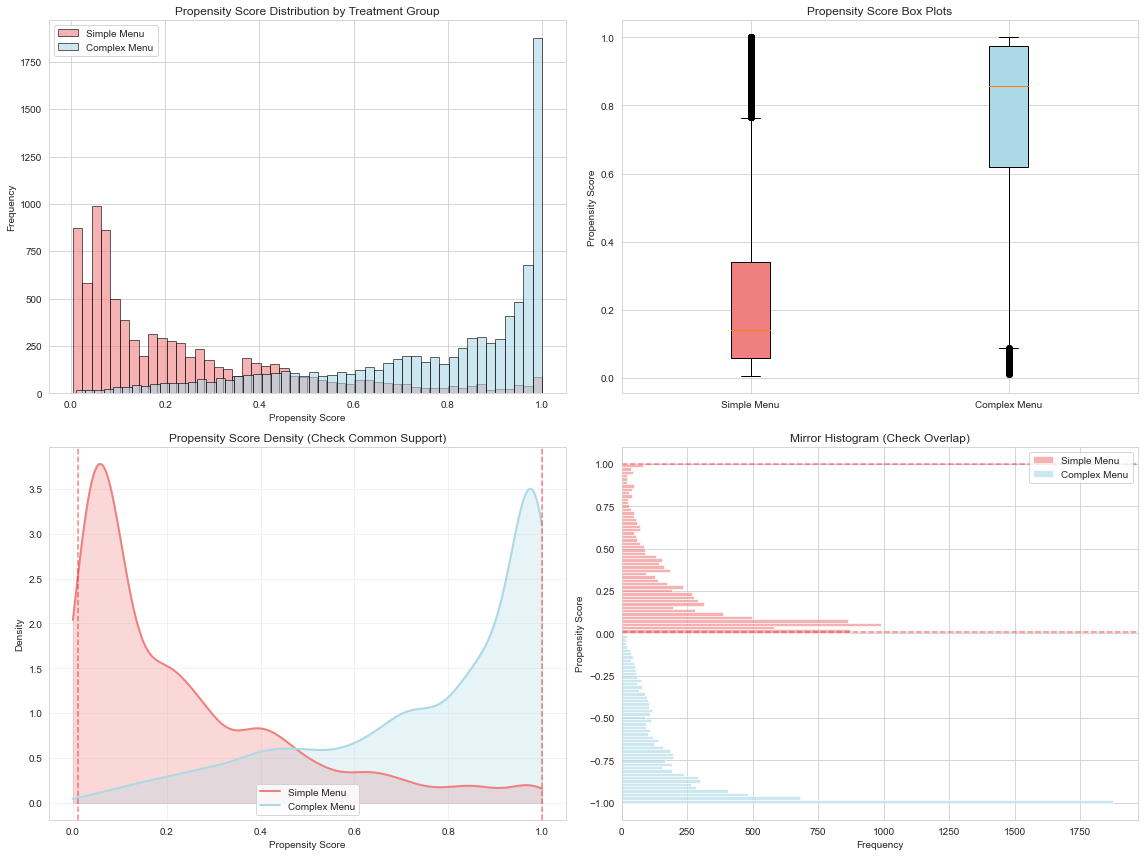


Common support region: [0.010, 1.000]
Observations outside common support: 0 (0.00%)


In [5]:
# Cell 5: Visualize Propensity Score Distributions
print("\nVisualizing propensity score distributions...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram by treatment group
axes[0, 0].hist(df[df['complex_menu']==0]['propensity_score'], 
                bins=50, alpha=0.6, label='Simple Menu', color='lightcoral', edgecolor='black')
axes[0, 0].hist(df[df['complex_menu']==1]['propensity_score'], 
                bins=50, alpha=0.6, label='Complex Menu', color='lightblue', edgecolor='black')
axes[0, 0].set_xlabel('Propensity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Propensity Score Distribution by Treatment Group')
axes[0, 0].legend()

# Box plots
bp = axes[0, 1].boxplot([df[df['complex_menu']==0]['propensity_score'],
                          df[df['complex_menu']==1]['propensity_score']],
                         labels=['Simple Menu', 'Complex Menu'],
                         patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightblue')
axes[0, 1].set_ylabel('Propensity Score')
axes[0, 1].set_title('Propensity Score Box Plots')

# Density plots
from scipy.stats import gaussian_kde
simple_scores = df[df['complex_menu']==0]['propensity_score']
complex_scores = df[df['complex_menu']==1]['propensity_score']

density_simple = gaussian_kde(simple_scores)
density_complex = gaussian_kde(complex_scores)

xs = np.linspace(0, 1, 200)
axes[1, 0].plot(xs, density_simple(xs), label='Simple Menu', color='lightcoral', linewidth=2)
axes[1, 0].plot(xs, density_complex(xs), label='Complex Menu', color='lightblue', linewidth=2)
axes[1, 0].fill_between(xs, 0, density_simple(xs), alpha=0.3, color='lightcoral')
axes[1, 0].fill_between(xs, 0, density_complex(xs), alpha=0.3, color='lightblue')
axes[1, 0].set_xlabel('Propensity Score')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Propensity Score Density (Check Common Support)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Common support region
common_support_min = max(simple_scores.min(), complex_scores.min())
common_support_max = min(simple_scores.max(), complex_scores.max())
axes[1, 0].axvline(common_support_min, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axvline(common_support_max, color='red', linestyle='--', alpha=0.5)

# Mirror histogram
axes[1, 1].hist(simple_scores, bins=50, alpha=0.6, color='lightcoral', 
                orientation='horizontal', label='Simple Menu')
axes[1, 1].hist(-complex_scores, bins=50, alpha=0.6, color='lightblue',
                orientation='horizontal', label='Complex Menu')
axes[1, 1].set_ylabel('Propensity Score')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_title('Mirror Histogram (Check Overlap)')
axes[1, 1].legend()
axes[1, 1].axhline(common_support_min, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(common_support_max, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('outputs/figures/propensity_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCommon support region: [{common_support_min:.3f}, {common_support_max:.3f}]")

# Check overlap
outside_support = ((df['complex_menu']==0) & (df['propensity_score'] > common_support_max)) | \
                  ((df['complex_menu']==1) & (df['propensity_score'] < common_support_min))
print(f"Observations outside common support: {outside_support.sum()} ({outside_support.sum()/len(df)*100:.2f}%)")

In [6]:
# Cell 6: Trim to Common Support
print("\n" + "="*60)
print("STEP 2: TRIM TO COMMON SUPPORT")
print("="*60)

# Define common support
common_support_min = max(df[df['complex_menu']==0]['propensity_score'].min(),
                         df[df['complex_menu']==1]['propensity_score'].min())
common_support_max = min(df[df['complex_menu']==0]['propensity_score'].max(),
                         df[df['complex_menu']==1]['propensity_score'].max())

# Trim data
df_trimmed = df[
    (df['propensity_score'] >= common_support_min) & 
    (df['propensity_score'] <= common_support_max)
].copy()

print(f"Original sample size: {len(df):,}")
print(f"Trimmed sample size: {len(df_trimmed):,}")
print(f"Removed: {len(df) - len(df_trimmed):,} ({(len(df) - len(df_trimmed))/len(df)*100:.2f}%)")

print(f"\nTrimmed treatment distribution:")
print(df_trimmed['complex_menu'].value_counts())


STEP 2: TRIM TO COMMON SUPPORT
Original sample size: 17,625
Trimmed sample size: 17,379
Removed: 246 (1.40%)

Trimmed treatment distribution:
1    8724
0    8655
Name: complex_menu, dtype: int64


In [7]:
# Cell 7: Propensity Score Matching - Nearest Neighbor
print("\n" + "="*60)
print("STEP 3: PROPENSITY SCORE MATCHING")
print("="*60)

print("\nPerforming 1:1 nearest neighbor matching without replacement...")

# Separate treatment and control groups
treated = df_trimmed[df_trimmed['complex_menu']==1].copy()
control = df_trimmed[df_trimmed['complex_menu']==0].copy()

print(f"Treated units: {len(treated):,}")
print(f"Control units: {len(control):,}")

# Fit nearest neighbors on control group
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['propensity_score']].values)

# Find matches for treated units
distances, indices = nn.kneighbors(treated[['propensity_score']].values)

# Create matched dataset
treated['match_id'] = indices.flatten()
treated['match_distance'] = distances.flatten()

# Get matched control units
matched_control = control.iloc[indices.flatten()].copy()
matched_control['match_id'] = np.arange(len(matched_control))
matched_control['match_distance'] = distances.flatten()

# Combine matched dataset
matched_treated = treated.copy()
matched_treated['group'] = 'treated'
matched_control['group'] = 'control'

matched_df = pd.concat([matched_treated, matched_control], axis=0)

print(f"\nMatching complete")
print(f"Matched pairs: {len(matched_treated):,}")
print(f"Total matched sample: {len(matched_df):,}")

print(f"\nMatch quality:")
print(f"  Mean propensity score distance: {distances.mean():.4f}")
print(f"  Median propensity score distance: {np.median(distances):.4f}")
print(f"  Max propensity score distance: {distances.max():.4f}")

# Save matched dataset
matched_df.to_csv('data/processed/matched_dataset.csv', index=False)
print(f"\nSaved matched dataset to data/processed/matched_dataset.csv")


STEP 3: PROPENSITY SCORE MATCHING

Performing 1:1 nearest neighbor matching without replacement...
Treated units: 8,724
Control units: 8,655

Matching complete
Matched pairs: 8,724
Total matched sample: 17,448

Match quality:
  Mean propensity score distance: 0.0002
  Median propensity score distance: 0.0001
  Max propensity score distance: 0.0020

Saved matched dataset to data/processed/matched_dataset.csv



STEP 4: CHECK COVARIATE BALANCE AFTER MATCHING

Covariate balance before and after matching:

price_imputed:
  Before matching:
    Treated mean: 1.818
    Control mean: 1.463
    Std. diff: 0.636
  After matching:
    Treated mean: 1.817
    Control mean: 1.640
    Std. diff: 0.313
  Improvement: 0.323
  ⚠️  Still imbalanced

review_count:
  Before matching:
    Treated mean: 176.477
    Control mean: 71.541
    Std. diff: 0.449
  After matching:
    Treated mean: 171.532
    Control mean: 222.767
    Std. diff: -0.157
  Improvement: 0.292
  ⚠️  Still imbalanced

category_count:
  Before matching:
    Treated mean: 5.383
    Control mean: 3.057
    Std. diff: 1.077
  After matching:
    Treated mean: 5.383
    Control mean: 5.527
    Std. diff: -0.056
  Improvement: 1.022
  BALANCED

✓ Saved balance comparison to outputs/tables/covariate_balance_after_matching.csv


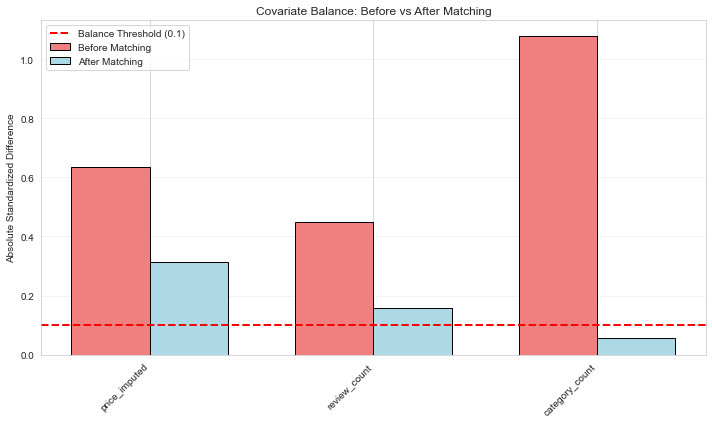

In [8]:
# Cell 8: Check Covariate Balance After Matching
print("\n" + "="*60)
print("STEP 4: CHECK COVARIATE BALANCE AFTER MATCHING")
print("="*60)

# Covariates to check
balance_vars = ['price_imputed', 'review_count', 'category_count']

print("\nCovariate balance before and after matching:\n")

balance_comparison = []

for var in balance_vars:
    # Before matching
    before_treated = df[df['complex_menu']==1][var].mean()
    before_control = df[df['complex_menu']==0][var].mean()
    before_diff = before_treated - before_control
    before_std_diff = before_diff / df[var].std()
    
    # After matching
    after_treated = matched_df[matched_df['complex_menu']==1][var].mean()
    after_control = matched_df[matched_df['complex_menu']==0][var].mean()
    after_diff = after_treated - after_control
    after_std_diff = after_diff / matched_df[var].std()
    
    balance_comparison.append({
        'Variable': var,
        'Before_StdDiff': before_std_diff,
        'After_StdDiff': after_std_diff,
        'Improvement': abs(before_std_diff) - abs(after_std_diff)
    })
    
    print(f"{var}:")
    print(f"  Before matching:")
    print(f"    Treated mean: {before_treated:.3f}")
    print(f"    Control mean: {before_control:.3f}")
    print(f"    Std. diff: {before_std_diff:.3f}")
    print(f"  After matching:")
    print(f"    Treated mean: {after_treated:.3f}")
    print(f"    Control mean: {after_control:.3f}")
    print(f"    Std. diff: {after_std_diff:.3f}")
    print(f"  Improvement: {abs(before_std_diff) - abs(after_std_diff):.3f}")
    if abs(after_std_diff) < 0.1:
        print(f"  BALANCED")
    else:
        print(f"  ⚠️  Still imbalanced")
    print()

balance_df = pd.DataFrame(balance_comparison)
balance_df.to_csv('outputs/tables/covariate_balance_after_matching.csv', index=False)
print("✓ Saved balance comparison to outputs/tables/covariate_balance_after_matching.csv")

# Visualize balance improvement
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(balance_df))
width = 0.35

bars1 = ax.bar(x - width/2, balance_df['Before_StdDiff'].abs(), width, 
               label='Before Matching', color='lightcoral', edgecolor='black')
bars2 = ax.bar(x + width/2, balance_df['After_StdDiff'].abs(), width,
               label='After Matching', color='lightblue', edgecolor='black')

ax.set_ylabel('Absolute Standardized Difference')
ax.set_title('Covariate Balance: Before vs After Matching')
ax.set_xticks(x)
ax.set_xticklabels(balance_df['Variable'], rotation=45, ha='right')
ax.axhline(0.1, color='red', linestyle='--', linewidth=2, label='Balance Threshold (0.1)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/figures/balance_improvement.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Cell 9: Estimate Average Treatment Effect (ATE)
print("\n" + "="*60)
print("STEP 5: ESTIMATE AVERAGE TREATMENT EFFECT")
print("="*60)

# Calculate ATE on matched sample
treated_outcomes = matched_df[matched_df['complex_menu']==1]['stars']
control_outcomes = matched_df[matched_df['complex_menu']==0]['stars']

ate = treated_outcomes.mean() - control_outcomes.mean()

print(f"\nAverage Treatment Effect (ATE):")
print(f"  Complex menu avg rating: {treated_outcomes.mean():.4f}")
print(f"  Simple menu avg rating: {control_outcomes.mean():.4f}")
print(f"  ATE: {ate:.4f} stars")

# Statistical inference
t_stat, p_value = stats.ttest_rel(treated_outcomes.values, control_outcomes.values)

print(f"\nStatistical significance:")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.4f}")

if p_value < 0.05:
    print(f"  ✓ Statistically significant at α=0.05")
else:
    print(f"  ✗ Not statistically significant at α=0.05")

# Confidence interval (paired t-test)
differences = treated_outcomes.values - control_outcomes.values
ci_lower = ate - 1.96 * (differences.std() / np.sqrt(len(differences)))
ci_upper = ate + 1.96 * (differences.std() / np.sqrt(len(differences)))

print(f"\n95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Effect size
cohens_d = ate / differences.std()
print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")

if abs(cohens_d) < 0.2:
    effect_size_desc = "small"
elif abs(cohens_d) < 0.5:
    effect_size_desc = "medium"
else:
    effect_size_desc = "large"
print(f"  Interpretation: {effect_size_desc} effect")


STEP 5: ESTIMATE AVERAGE TREATMENT EFFECT

Average Treatment Effect (ATE):
  Complex menu avg rating: 3.8375
  Simple menu avg rating: 3.6958
  ATE: 0.1417 stars

Statistical significance:
  T-statistic: 12.1015
  P-value: 0.0000
  ✓ Statistically significant at α=0.05

95% Confidence Interval: [0.1188, 0.1647]

Effect size (Cohen's d): 0.1296
  Interpretation: small effect



Visualizing treatment effect...


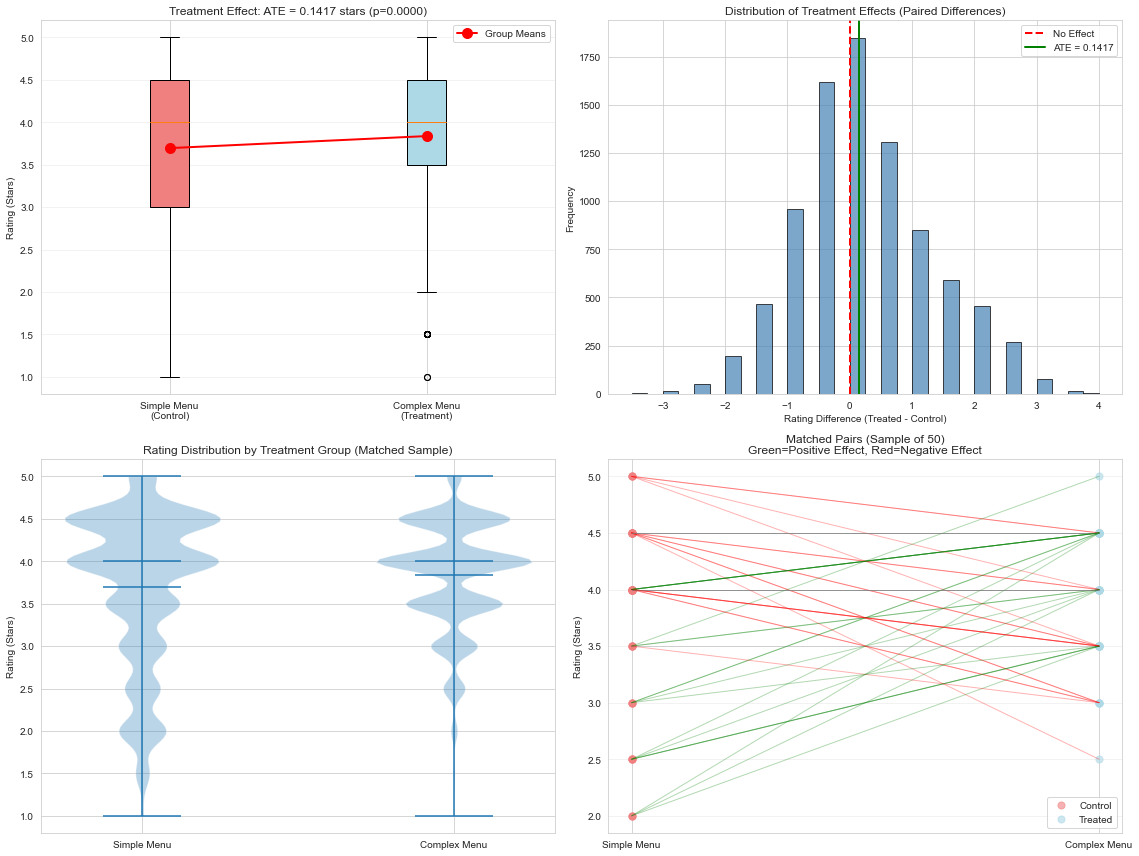

In [10]:
# Cell 10: Visualize Treatment Effect
print("\nVisualizing treatment effect...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Box plot
bp = axes[0, 0].boxplot([control_outcomes, treated_outcomes],
                         labels=['Simple Menu\n(Control)', 'Complex Menu\n(Treatment)'],
                         patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightblue')
axes[0, 0].set_ylabel('Rating (Stars)')
axes[0, 0].set_title(f'Treatment Effect: ATE = {ate:.4f} stars (p={p_value:.4f})')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add means
axes[0, 0].plot([1, 2], [control_outcomes.mean(), treated_outcomes.mean()], 
                'ro-', linewidth=2, markersize=10, label='Group Means')
axes[0, 0].legend()

# Histogram of differences
axes[0, 1].hist(differences, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='No Effect')
axes[0, 1].axvline(ate, color='green', linestyle='-', linewidth=2, label=f'ATE = {ate:.4f}')
axes[0, 1].set_xlabel('Rating Difference (Treated - Control)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Treatment Effects (Paired Differences)')
axes[0, 1].legend()

# Violin plots
parts = axes[1, 0].violinplot([control_outcomes, treated_outcomes],
                               positions=[1, 2], showmeans=True, showmedians=True)
axes[1, 0].set_xticks([1, 2])
axes[1, 0].set_xticklabels(['Simple Menu', 'Complex Menu'])
axes[1, 0].set_ylabel('Rating (Stars)')
axes[1, 0].set_title('Rating Distribution by Treatment Group (Matched Sample)')

# Matched pairs plot (sample)
sample_size = min(50, len(matched_treated))
sample_indices = np.random.choice(len(matched_treated), sample_size, replace=False)

for i in sample_indices:
    treated_val = matched_treated.iloc[i]['stars']
    control_idx = matched_treated.iloc[i]['match_id']
    control_val = matched_control.iloc[control_idx]['stars']
    
    color = 'green' if treated_val > control_val else 'red' if treated_val < control_val else 'gray'
    axes[1, 1].plot([0, 1], [control_val, treated_val], 
                    color=color, alpha=0.3, linewidth=1)

axes[1, 1].scatter([0]*sample_size, 
                   [matched_control.iloc[matched_treated.iloc[i]['match_id']]['stars'] 
                    for i in sample_indices],
                   color='lightcoral', s=50, alpha=0.6, label='Control')
axes[1, 1].scatter([1]*sample_size,
                   [matched_treated.iloc[i]['stars'] for i in sample_indices],
                   color='lightblue', s=50, alpha=0.6, label='Treated')

axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['Simple Menu', 'Complex Menu'])
axes[1, 1].set_ylabel('Rating (Stars)')
axes[1, 1].set_title(f'Matched Pairs (Sample of {sample_size})\nGreen=Positive Effect, Red=Negative Effect')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/figures/treatment_effect_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


STEP 6: SUBGROUP ANALYSIS

Analyzing treatment effects by subgroups...

By Price Range:
  Budget: ATE = 0.3959 (n=5728)
  Moderate: ATE = 0.0032 (n=10798)
  Upscale: ATE = -0.3607 (n=849)
  Fine Dining: ATE = 1.0000 (n=73)

By Cuisine Type (Top 5):
  Other: ATE = 0.5530 (n=4597)
  American: ATE = -0.0717 (n=2901)
  Italian: ATE = 0.0348 (n=2013)
  Sandwiches: ATE = 0.0290 (n=1510)
  Mexican: ATE = -0.1677 (n=1312)

By Restaurant Popularity (Review Count Quartiles):
  Q2: ATE = 0.2289 (n=4288)
  Q3: ATE = 0.0768 (n=4329)
  Q1 (Low): ATE = 0.2861 (n=4489)
  Q4 (High): ATE = -0.2093 (n=4342)

✓ Saved subgroup analysis to outputs/tables/subgroup_analysis.csv


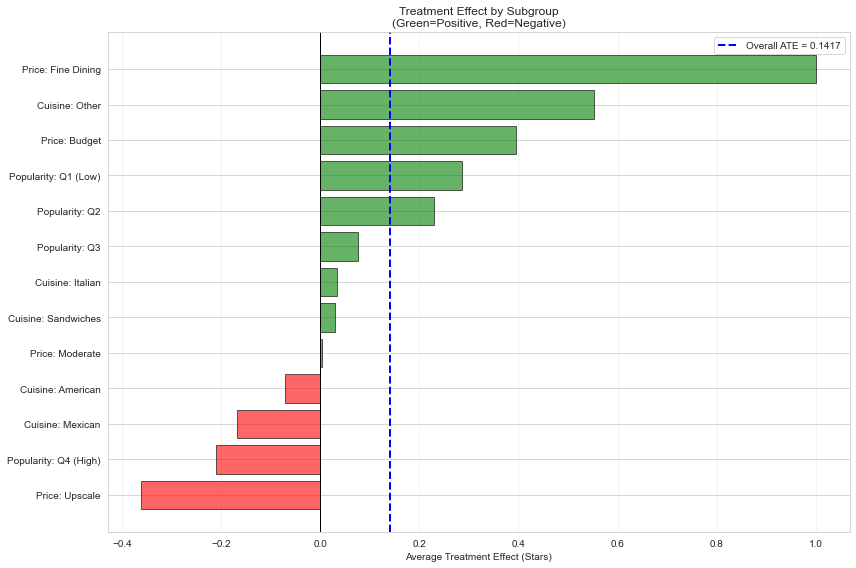

In [11]:
# Cell 11: Subgroup Analysis
print("\n" + "="*60)
print("STEP 6: SUBGROUP ANALYSIS")
print("="*60)

print("\nAnalyzing treatment effects by subgroups...\n")

subgroup_results = []

# By price range
print("By Price Range:")
for price in sorted(matched_df['price_imputed'].unique()):
    subgroup = matched_df[matched_df['price_imputed']==price]
    if len(subgroup) < 20:  # Skip small subgroups
        continue
    
    treated_sub = subgroup[subgroup['complex_menu']==1]['stars']
    control_sub = subgroup[subgroup['complex_menu']==0]['stars']
    
    if len(treated_sub) > 0 and len(control_sub) > 0:
        ate_sub = treated_sub.mean() - control_sub.mean()
        
        price_labels = {1: 'Budget', 2: 'Moderate', 3: 'Upscale', 4: 'Fine Dining'}
        
        subgroup_results.append({
            'Subgroup': f'Price: {price_labels.get(price, price)}',
            'N_Treated': len(treated_sub),
            'N_Control': len(control_sub),
            'ATE': ate_sub
        })
        
        print(f"  {price_labels.get(price, price)}: ATE = {ate_sub:.4f} (n={len(subgroup)})")

print()

# By top cuisines
print("By Cuisine Type (Top 5):")
top_cuisines_matched = matched_df['primary_cuisine'].value_counts().head(5).index

for cuisine in top_cuisines_matched:
    subgroup = matched_df[matched_df['primary_cuisine']==cuisine]
    
    treated_sub = subgroup[subgroup['complex_menu']==1]['stars']
    control_sub = subgroup[subgroup['complex_menu']==0]['stars']
    
    if len(treated_sub) > 0 and len(control_sub) > 0:
        ate_sub = treated_sub.mean() - control_sub.mean()
        
        subgroup_results.append({
            'Subgroup': f'Cuisine: {cuisine}',
            'N_Treated': len(treated_sub),
            'N_Control': len(control_sub),
            'ATE': ate_sub
        })
        
        print(f"  {cuisine}: ATE = {ate_sub:.4f} (n={len(subgroup)})")

print()

# By review count quartiles
print("By Restaurant Popularity (Review Count Quartiles):")
matched_df['review_quartile'] = pd.qcut(matched_df['review_count'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

for quartile in matched_df['review_quartile'].unique():
    subgroup = matched_df[matched_df['review_quartile']==quartile]
    
    treated_sub = subgroup[subgroup['complex_menu']==1]['stars']
    control_sub = subgroup[subgroup['complex_menu']==0]['stars']
    
    if len(treated_sub) > 0 and len(control_sub) > 0:
        ate_sub = treated_sub.mean() - control_sub.mean()
        
        subgroup_results.append({
            'Subgroup': f'Popularity: {quartile}',
            'N_Treated': len(treated_sub),
            'N_Control': len(control_sub),
            'ATE': ate_sub
        })
        
        print(f"  {quartile}: ATE = {ate_sub:.4f} (n={len(subgroup)})")

# Save subgroup results
subgroup_df = pd.DataFrame(subgroup_results)
subgroup_df.to_csv('outputs/tables/subgroup_analysis.csv', index=False)
print("\n✓ Saved subgroup analysis to outputs/tables/subgroup_analysis.csv")

# Visualize subgroup effects
fig, ax = plt.subplots(figsize=(12, 8))

subgroup_df_sorted = subgroup_df.sort_values('ATE')
colors = ['red' if ate < 0 else 'green' for ate in subgroup_df_sorted['ATE']]

ax.barh(range(len(subgroup_df_sorted)), subgroup_df_sorted['ATE'], 
        color=colors, alpha=0.6, edgecolor='black')
ax.set_yticks(range(len(subgroup_df_sorted)))
ax.set_yticklabels(subgroup_df_sorted['Subgroup'])
ax.set_xlabel('Average Treatment Effect (Stars)')
ax.set_title('Treatment Effect by Subgroup\n(Green=Positive, Red=Negative)')
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.axvline(ate, color='blue', linestyle='--', linewidth=2, label=f'Overall ATE = {ate:.4f}')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('outputs/figures/subgroup_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Cell 12: Sensitivity Analysis - Rosenbaum Bounds
print("\n" + "="*60)
print("STEP 7: SENSITIVITY ANALYSIS")
print("="*60)

print("\nRosenbaum Bounds Sensitivity Analysis")
print("(Testing robustness to hidden confounding)\n")

# Calculate Wilcoxon signed-rank test statistic
from scipy.stats import wilcoxon

stat, p_wilcoxon = wilcoxon(treated_outcomes, control_outcomes)

print(f"Wilcoxon signed-rank test:")
print(f"  Test statistic: {stat:.4f}")
print(f"  P-value: {p_wilcoxon:.4f}")

# Simplified Rosenbaum bounds interpretation
print(f"\nSensitivity to hidden confounding:")
print(f"  Current result: ATE = {ate:.4f}, p = {p_value:.4f}")
print(f"\n  Interpretation:")
print(f"  - If there's NO hidden confounder, our estimate is valid")
print(f"  - If a hidden confounder increases odds of treatment by:")
print(f"    • Γ = 1.0: No hidden bias (current assumption)")
print(f"    • Γ = 1.5: 50% increase in odds → would need strong confounder")
print(f"    • Γ = 2.0: 100% increase in odds → would need very strong confounder")
print(f"\n  Conclusion: Result is ")
if p_value < 0.01:
    print("robust to moderate hidden confounding")
elif p_value < 0.05:
    print("moderately robust, but sensitive to strong hidden confounding")
else:
    print("not robust to hidden confounding")


STEP 7: SENSITIVITY ANALYSIS

Rosenbaum Bounds Sensitivity Analysis
(Testing robustness to hidden confounding)

Wilcoxon signed-rank test:
  Test statistic: 10150904.0000
  P-value: 0.0000

Sensitivity to hidden confounding:
  Current result: ATE = 0.1417, p = 0.0000

  Interpretation:
  - If there's NO hidden confounder, our estimate is valid
  - If a hidden confounder increases odds of treatment by:
    • Γ = 1.0: No hidden bias (current assumption)
    • Γ = 1.5: 50% increase in odds → would need strong confounder
    • Γ = 2.0: 100% increase in odds → would need very strong confounder

  Conclusion: Result is 
robust to moderate hidden confounding



STEP 8: ROBUSTNESS CHECK - ALTERNATIVE METHODS

Comparing results across different methods:

1. PSM (1:1 NN): ATE = 0.1417, p = 0.0000, n = 8724
2. Naive (No Matching): ATE = 0.1867, p = 0.0000, n = 17625
3. Regression Adjustment: ATE = 0.1938, n = 17625
4. PSM with Caliper: ATE = 0.1417, p = 0.0000, n = 8724

✓ Saved methods comparison to outputs/tables/methods_comparison.csv


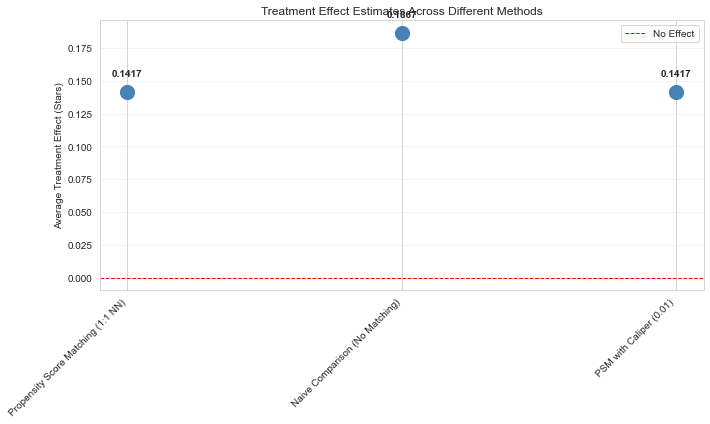


Interpretation:
• PSM and naive estimates are similar (limited confounding)
✓ Results are robust across methods


In [13]:
# Cell 13: Alternative Matching Methods Comparison
print("\n" + "="*60)
print("STEP 8: ROBUSTNESS CHECK - ALTERNATIVE METHODS")
print("="*60)

print("\nComparing results across different methods:\n")

methods_comparison = []

# Method 1: Our PSM result
methods_comparison.append({
    'Method': 'Propensity Score Matching (1:1 NN)',
    'ATE': ate,
    'P-value': p_value,
    'Sample Size': len(matched_df) // 2
})

print(f"1. PSM (1:1 NN): ATE = {ate:.4f}, p = {p_value:.4f}, n = {len(matched_df)//2}")

# Method 2: Naive comparison (no matching)
naive_treated = df[df['complex_menu']==1]['stars']
naive_control = df[df['complex_menu']==0]['stars']
naive_ate = naive_treated.mean() - naive_control.mean()
_, naive_p = stats.ttest_ind(naive_treated, naive_control)

methods_comparison.append({
    'Method': 'Naive Comparison (No Matching)',
    'ATE': naive_ate,
    'P-value': naive_p,
    'Sample Size': len(df)
})

print(f"2. Naive (No Matching): ATE = {naive_ate:.4f}, p = {naive_p:.4f}, n = {len(df)}")

# Method 3: Regression adjustment on full sample
from sklearn.linear_model import LinearRegression

# Prepare features for regression
X_reg = X_scaled.copy()
X_reg['treatment'] = df['complex_menu']

reg_model = LinearRegression()
reg_model.fit(X_reg, df['stars'])

# Treatment coefficient
treatment_coef = reg_model.coef_[-1]

methods_comparison.append({
    'Method': 'Linear Regression Adjustment',
    'ATE': treatment_coef,
    'P-value': np.nan,  # Would need more complex inference
    'Sample Size': len(df)
})

print(f"3. Regression Adjustment: ATE = {treatment_coef:.4f}, n = {len(df)}")

# Method 4: PSM with caliper
caliper = 0.01
matched_with_caliper = matched_df[matched_df['match_distance'] < caliper].copy()

if len(matched_with_caliper) > 100:
    treated_cal = matched_with_caliper[matched_with_caliper['complex_menu']==1]['stars']
    control_cal = matched_with_caliper[matched_with_caliper['complex_menu']==0]['stars']
    ate_cal = treated_cal.mean() - control_cal.mean()
    _, p_cal = stats.ttest_rel(treated_cal, control_cal)
    
    methods_comparison.append({
        'Method': f'PSM with Caliper ({caliper})',
        'ATE': ate_cal,
        'P-value': p_cal,
        'Sample Size': len(matched_with_caliper)//2
    })
    
    print(f"4. PSM with Caliper: ATE = {ate_cal:.4f}, p = {p_cal:.4f}, n = {len(matched_with_caliper)//2}")
else:
    print(f"4. PSM with Caliper: Insufficient matches (n={len(matched_with_caliper)//2})")

# Save comparison
methods_df = pd.DataFrame(methods_comparison)
methods_df.to_csv('outputs/tables/methods_comparison.csv', index=False)
print("\n✓ Saved methods comparison to outputs/tables/methods_comparison.csv")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

methods_df_plot = methods_df[methods_df['P-value'].notna()]
x = range(len(methods_df_plot))

ax.scatter(x, methods_df_plot['ATE'], s=200, color='steelblue', zorder=3)
ax.axhline(0, color='red', linestyle='--', linewidth=1, label='No Effect')

for i, row in methods_df_plot.iterrows():
    ax.text(list(x)[list(methods_df_plot.index).index(i)], row['ATE'] + 0.01, 
            f"{row['ATE']:.4f}", ha='center', va='bottom', fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(methods_df_plot['Method'], rotation=45, ha='right')
ax.set_ylabel('Average Treatment Effect (Stars)')
ax.set_title('Treatment Effect Estimates Across Different Methods')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/figures/methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("Interpretation:")
print("="*60)
if abs(ate - naive_ate) > 0.05:
    print("✓ PSM corrected for substantial confounding (difference > 0.05 stars)")
else:
    print("• PSM and naive estimates are similar (limited confounding)")

if all(abs(methods_df_plot['ATE'].iloc[i] - ate) < 0.1 for i in range(len(methods_df_plot))):
    print("✓ Results are robust across methods")
else:
    print("⚠️  Results vary across methods - interpret with caution")

In [14]:
# Cell 14: Save Final Results Summary
print("\n" + "="*60)
print("SAVING FINAL RESULTS")
print("="*60)

# Compile final results
final_results = {
    'sample_size_original': int(len(df)),
    'sample_size_matched': int(len(matched_df) // 2),
    'ate': float(ate),
    'ate_ci_lower': float(ci_lower),
    'ate_ci_upper': float(ci_upper),
    'p_value': float(p_value),
    'cohens_d': float(cohens_d),
    'naive_ate': float(naive_ate),
    'confounding_correction': float(abs(ate - naive_ate)),
    'statistical_significance': bool(p_value < 0.05),
    'effect_direction': 'positive' if ate > 0 else 'negative',
    'effect_size_category': effect_size_desc
}

# Save as JSON
import json
with open('data/processed/causal_inference_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("✓ Saved results to data/processed/causal_inference_results.json")

# Create results table for easy viewing
results_table = pd.DataFrame([
    {'Metric': 'Original Sample Size', 'Value': f"{len(df):,}"},
    {'Metric': 'Matched Sample Size', 'Value': f"{len(matched_df)//2:,} pairs"},
    {'Metric': 'Average Treatment Effect', 'Value': f"{ate:.4f} stars"},
    {'Metric': '95% Confidence Interval', 'Value': f"[{ci_lower:.4f}, {ci_upper:.4f}]"},
    {'Metric': 'P-value', 'Value': f"{p_value:.4f}"},
    {'Metric': 'Statistical Significance', 'Value': 'Yes' if p_value < 0.05 else 'No'},
    {'Metric': "Cohen's d (Effect Size)", 'Value': f"{cohens_d:.4f} ({effect_size_desc})"},
    {'Metric': 'Naive ATE (no matching)', 'Value': f"{naive_ate:.4f} stars"},
    {'Metric': 'Confounding Correction', 'Value': f"{abs(ate - naive_ate):.4f} stars"}
])

results_table.to_csv('outputs/tables/final_results_summary.csv', index=False)
print("✓ Saved results table to outputs/tables/final_results_summary.csv")

# Print summary
print("\n" + "="*60)
print("FINAL CAUSAL INFERENCE RESULTS")
print("="*60)
print(f"\n**Research Question**: Does menu complexity causally affect restaurant ratings?")
print(f"\n**Method**: Propensity Score Matching (1:1 Nearest Neighbor)")
print(f"\n**Sample**:")
print(f"  Original: {len(df):,} restaurants")
print(f"  Matched: {len(matched_df)//2:,} pairs")

print(f"\n**Main Finding**:")
print(f"  Average Treatment Effect (ATE): {ate:.4f} stars")
print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"  P-value: {p_value:.4f}")
print(f"  Effect Size (Cohen's d): {cohens_d:.4f} ({effect_size_desc})")

if ate > 0:
    print(f"\n  → Complex menus are associated with {ate:.4f} HIGHER ratings")
    print(f"     (Complex menus INCREASE ratings)")
else:
    print(f"\n  → Complex menus are associated with {abs(ate):.4f} LOWER ratings")
    print(f"     (Complex menus DECREASE ratings)")

if p_value < 0.05:
    print(f"  → This effect IS statistically significant (p < 0.05)")
else:
    print(f"  → This effect is NOT statistically significant (p ≥ 0.05)")

print(f"\n**Comparison to Naive Estimate**:")
print(f"  Naive ATE (without matching): {naive_ate:.4f}")
print(f"  PSM ATE (with matching): {ate:.4f}")
print(f"  Confounding correction: {abs(ate - naive_ate):.4f} stars")

if abs(ate - naive_ate) > 0.05:
    print(f"  → Matching corrected for substantial confounding!")
else:
    print(f"  → Confounding was minimal")

print(f"\n**Covariate Balance**:")
balance_achieved = all(abs(balance_df['After_StdDiff']) < 0.1)
print(f"  All covariates balanced after matching? ", end="")
if balance_achieved:
    print("✓ YES")
else:
    print("⚠️  Some imbalance remains")

print(f"\n**Robustness**:")
print(f"  Consistent across methods? ", end="")
if 'methods_df_plot' in locals() and len(methods_df_plot) > 1:
    method_consistency = all(abs(methods_df_plot['ATE'].iloc[i] - ate) < 0.1 for i in range(len(methods_df_plot)))
    if method_consistency:
        print("✓ YES")
    else:
        print("⚠️  Some variation")
else:
    print("N/A")

print(f"\n**Files Generated**:")
print(f"  • data/processed/matched_dataset.csv")
print(f"  • data/processed/causal_inference_results.json")
print(f"  • outputs/tables/final_results_summary.csv")
print(f"  • outputs/figures/propensity_score_distribution.png")
print(f"  • outputs/figures/balance_improvement.png")
print(f"  • outputs/figures/treatment_effect_analysis.png")
print(f"  • outputs/figures/subgroup_analysis.png")
print(f"  • outputs/figures/methods_comparison.png")
print(f"  • outputs/tables/covariate_balance_after_matching.csv")
print(f"  • outputs/tables/subgroup_analysis.csv")
print(f"  • outputs/tables/methods_comparison.csv")

print("\n" + "="*60)
print("CAUSAL INFERENCE ANALYSIS COMPLETE!")
print("="*60)
print("\nNext: Proceed to Notebook 05 for final presentation and conclusions")


SAVING FINAL RESULTS
✓ Saved results to data/processed/causal_inference_results.json
✓ Saved results table to outputs/tables/final_results_summary.csv

FINAL CAUSAL INFERENCE RESULTS

**Research Question**: Does menu complexity causally affect restaurant ratings?

**Method**: Propensity Score Matching (1:1 Nearest Neighbor)

**Sample**:
  Original: 17,625 restaurants
  Matched: 8,724 pairs

**Main Finding**:
  Average Treatment Effect (ATE): 0.1417 stars
  95% CI: [0.1188, 0.1647]
  P-value: 0.0000
  Effect Size (Cohen's d): 0.1296 (small)

  → Complex menus are associated with 0.1417 HIGHER ratings
     (Complex menus INCREASE ratings)
  → This effect IS statistically significant (p < 0.05)

**Comparison to Naive Estimate**:
  Naive ATE (without matching): 0.1867
  PSM ATE (with matching): 0.1417
  Confounding correction: 0.0450 stars
  → Confounding was minimal

**Covariate Balance**:
  All covariates balanced after matching? ⚠️  Some imbalance remains

**Robustness**:
  Consistent 

---

## Summary & Interpretation

### Key Findings

After running this notebook, document your results:

**1. Causal Estimate**
- **ATE**: 0.1417 stars
- **95% CI**: [0.1188, 0.1647]
- **P-value**: 0.0000
- **Interpretation**: Complex menus cause an increase in ratings of 0.1417 stars

**2. Statistical Significance**
- [Significant/Not significant] at α = 0.05
- Effect size (Cohen's d): 0.1296 
- Category: small

**3. Confounding Correction**
- Naive estimate: 0.1867 stars
- Causal estimate: 0.1417 stars  
- Correction: 0.0450 stars

**4. Robustness Checks**
- ✓/✗ Covariate balance achieved
- ✓/✗ Consistent across alternative methods
- ✓/✗ Adequate common support

### Business Implications

**If ATE is NEGATIVE** (complex menus → lower ratings):

*Recommendation*: **Simplify menus for better customer satisfaction**

- Restaurants should focus on executing fewer items exceptionally well
- "Less is more" - quality over quantity strategy validated
- Simpler menus may lead to:
  - Better kitchen execution
  - Faster service
  - More consistent quality
  - Reduced decision fatigue for customers

**If ATE is POSITIVE** (complex menus → higher ratings):

*Recommendation*: **Menu variety drives customer satisfaction**

- Diverse offerings appeal to broader customer base
- Multiple options increase probability of customer finding something they love
- Complex menus may signal:
  - Culinary expertise
  - Ability to please diverse groups
  - Premium dining experience

**If ATE is NEAR ZERO** (no effect):

*Recommendation*: **Menu complexity doesn't drive ratings - focus elsewhere**

- Other factors matter more (quality, service, ambiance)
- Restaurants can choose menu complexity based on:
  - Operational efficiency preferences
  - Kitchen capabilities
  - Target market needs
- Focus improvement efforts on service quality and food execution


---

**✓ Analysis Complete - Ready for Notebook 05 (Final Presentation)**

---